# Predicting `audience_rating` Using  Machine Learning Techniques Using Selected Features

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading cleaned Rotten Tomatoes Dataset

In [4]:
import pandas as pd
df_movies = pd.read_csv('Downloads/rotten_tomatoes_cleaned.csv')

### Generating Summary Statistics for the Cleaned Dataset

In [5]:
df_movies.describe()

,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating
count,16637.000000,16637.000000,16637.000000,16637.000000
mean,102.392359,60.464146,56.609966,60.471578
std,24.911649,28.586446,66.384769,20.307185
min,1.000000,0.000000,5.000000,0.000000
25%,90.000000,38.000000,12.000000,45.000000
50%,99.000000,66.000000,28.000000,62.000000
75%,111.000000,86.000000,76.000000,77.000000
max,2000.000000,100.000000,497.000000,100.000000


### Dataset Information

In [6]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_title         16637 non-null  object 
 1   movie_info          16637 non-null  object 
 2   rating              16637 non-null  object 
 3   genre               16637 non-null  object 
 4   directors           16637 non-null  object 
 5   writers             16637 non-null  object 
 6   cast                16637 non-null  object 
 7   in_theaters_date    16637 non-null  object 
 8   on_streaming_date   16637 non-null  object 
 9   runtime_in_minutes  16637 non-null  float64
 10  studio_name         16637 non-null  object 
 11  tomatometer_status  16637 non-null  object 
 12  tomatometer_rating  16637 non-null  int64  
 13  tomatometer_count   16637 non-null  int64  
 14  audience_rating     16637 non-null  float64
dtypes: float64(2), int64(2), object(11)
memory usage: 1.9

### Plotting the Distribution of Audience Ratings

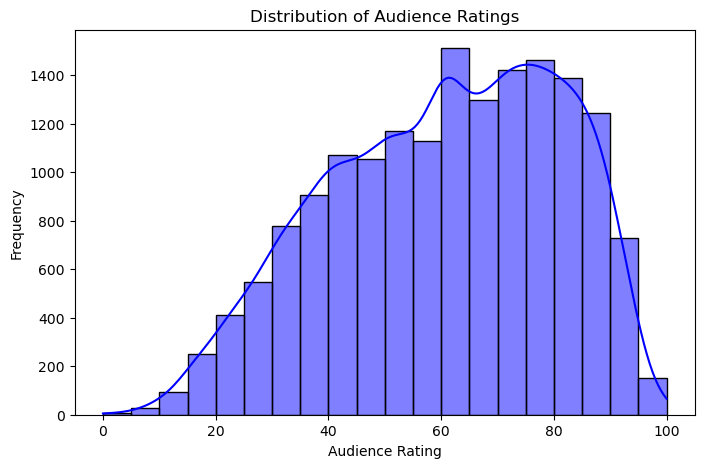

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df_movies, x='audience_rating', bins=20, kde=True, color='blue')
plt.title('Distribution of Audience Ratings')
plt.xlabel('Audience Rating')
plt.ylabel('Frequency')
plt.show()


### Scatter Plot: Audience Rating vs Tomatometer Rating

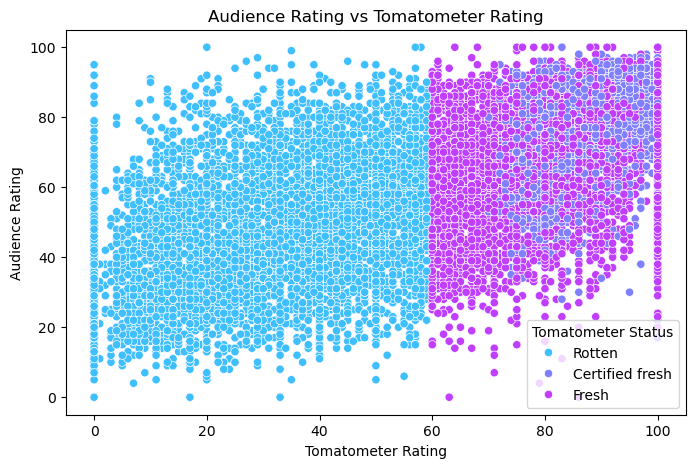

In [16]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_movies, x='tomatometer_rating', y='audience_rating', hue='tomatometer_status', palette='cool')
plt.title('Audience Rating vs Tomatometer Rating')
plt.xlabel('Tomatometer Rating')
plt.ylabel('Audience Rating')
plt.legend(title='Tomatometer Status')
plt.show()


### Building and Tuning the Support Vector Regression (SVR) Model

In [21]:
from sklearn.svm import SVR 

df_movies['rating'] = pd.to_numeric(df_movies['rating'], errors='coerce')
df_movies['tomatometer_rating'] = pd.to_numeric(df_movies['tomatometer_rating'], errors='coerce')
df_movies['tomatometer_count'] = pd.to_numeric(df_movies['tomatometer_count'], errors='coerce')

df_movies.fillna(0, inplace=True)

df_movies['runtime_to_rating'] = df_movies['runtime_in_minutes'] / (df_movies['tomatometer_rating'] + 1)
df_movies['rating_to_count'] = df_movies['rating'] / (df_movies['tomatometer_count'] + 1)


features = df_movies[['rating', 'genre', 'runtime_in_minutes', 'studio_name', 'tomatometer_rating', 'tomatometer_count', 'runtime_to_rating', 'rating_to_count']]
target = df_movies['audience_rating']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), features.select_dtypes(include=['float64', 'int64']).columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features.select_dtypes(include='object').columns)
    ]
)


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR())  
])

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

param_dist = {
    'model__C': [0.1, 1, 10, 100], 
    'model__epsilon': [0.01, 0.1, 0.2], 
    'model__kernel': ['linear', 'rbf', 'poly'], 
    'model__gamma': ['scale', 'auto'], 
    'model__degree': [2, 3, 4]  
}
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, cv=5, 
                                   scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)  
r2 = r2_score(y_test, y_pred)  

print("Best Hyperparameters:", best_params)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'model__kernel': 'linear', 'model__gamma': 'scale', 'model__epsilon': 0.2, 'model__degree': 2, 'model__C': 1}
Root Mean Squared Error (RMSE): 14.500587819752923
R² Score: 0.47886966218321236


C:\Users\Dalaali Gousiya\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Building and Tuning the Random Forest Regressor Model

In [22]:
from sklearn.ensemble import RandomForestRegressor 

df_movies['rating'] = pd.to_numeric(df_movies['rating'], errors='coerce')
df_movies['tomatometer_rating'] = pd.to_numeric(df_movies['tomatometer_rating'], errors='coerce')
df_movies['tomatometer_count'] = pd.to_numeric(df_movies['tomatometer_count'], errors='coerce')


df_movies.fillna(0, inplace=True)

df_movies['runtime_to_rating'] = df_movies['runtime_in_minutes'] / (df_movies['tomatometer_rating'] + 1)
df_movies['rating_to_count'] = df_movies['rating'] / (df_movies['tomatometer_count'] + 1)

features = df_movies[['rating', 'genre', 'runtime_in_minutes', 'studio_name', 
                      'tomatometer_rating', 'tomatometer_count', 
                      'runtime_to_rating', 'rating_to_count']]
target = df_movies['audience_rating']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), features.select_dtypes(include=['float64', 'int64']).columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features.select_dtypes(include='object').columns)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))  # Use RandomForestRegressor
])


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

param_dist = {
    'model__n_estimators': [100, 200, 300, 400],  
    'model__max_depth': [3, 5, 10, None], 
    'model__min_samples_split': [2, 5, 10],  
    'model__min_samples_leaf': [1, 2, 4],  
    'model__bootstrap': [True, False]
}


random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, cv=5, 
                                   scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)  
r2 = r2_score(y_test, y_pred)  

print("Best Hyperparameters:", best_params)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 10, 'model__bootstrap': True}
Root Mean Squared Error (RMSE): 14.629531269523513
R² Score: 0.46956036946969426


C:\Users\Dalaali Gousiya\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Building and Tuning the XGBoost Regressor Model

In [23]:
import xgboost as xgb

df_movies['rating'] = pd.to_numeric(df_movies['rating'], errors='coerce')
df_movies['tomatometer_rating'] = pd.to_numeric(df_movies['tomatometer_rating'], errors='coerce')
df_movies['tomatometer_count'] = pd.to_numeric(df_movies['tomatometer_count'], errors='coerce')

df_movies.fillna(0, inplace=True)

df_movies['runtime_to_rating'] = df_movies['runtime_in_minutes'] / (df_movies['tomatometer_rating'] + 1)
df_movies['rating_to_count'] = df_movies['rating'] / (df_movies['tomatometer_count'] + 1)

features = df_movies[['rating', 'genre', 'runtime_in_minutes', 'studio_name', 'tomatometer_rating', 'tomatometer_count', 'runtime_to_rating', 'rating_to_count']]
target = df_movies['audience_rating']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), features.select_dtypes(include=['float64', 'int64']).columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features.select_dtypes(include='object').columns)
    ]
)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

param_dist = {
    'model__n_estimators': [100, 200, 300, 400],  
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'model__max_depth': [3, 5, 7, 9], 
    'model__subsample': [0.7, 0.8, 1.0],  
    'model__colsample_bytree': [0.7, 0.8, 1.0], 
    'model__gamma': [0, 0.1, 0.5],  
    'model__min_child_weight': [1, 2, 3]  
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, cv=5, 
                                   scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'model__subsample': 0.8, 'model__n_estimators': 400, 'model__min_child_weight': 3, 'model__max_depth': 3, 'model__learning_rate': 0.2, 'model__gamma': 0, 'model__colsample_bytree': 0.7}
Root Mean Squared Error (RMSE): 14.116234899969069
R² Score: 0.5061297178564521


C:\Users\Dalaali Gousiya\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Actual vs Predicted Audience Ratings

To visually assess the performance of the model, I created a scatter plot comparing the actual audience ratings (`y_test`) with the predicted ratings (`y_pred`). Each point on the plot represents a pair of actual and predicted ratings for a movie.

A red dashed line is also plotted, representing the ideal scenario where the predicted ratings exactly match the actual ratings. The closer the blue points are to this line, the better the model's predictions.


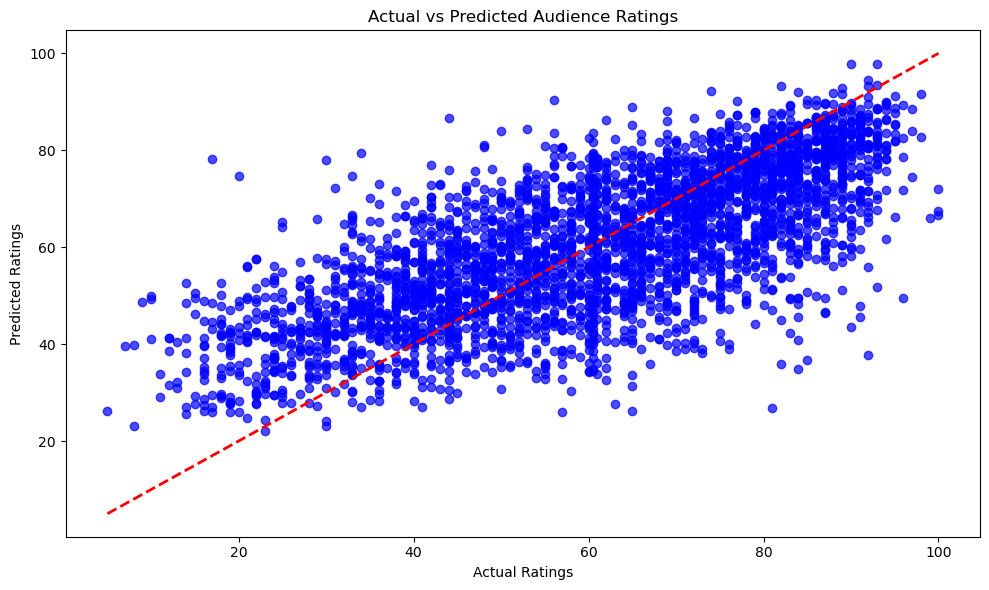

In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Actual vs Predicted Audience Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.tight_layout()
plt.show()
